# Import

In [1]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from transformers import DataCollatorWithPadding
# import optuna
from huggingface_hub import notebook_login
from sklearn.model_selection import StratifiedKFold

# lables value

# 2 = positive
# 1 = neutral
# 0 = negative

# Dataset

In [3]:
notebook_login()

Login successful
Your token has been saved to C:\Users\researcher\.huggingface\token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [20]:
dataset = load_dataset("HFFErica/Sentiment_Analysis_FinalBalanced")
dataset

In [21]:
folds = StratifiedKFold(n_splits=15)
splits = folds.split(np.zeros(dataset["train"].num_rows), dataset["train"]["label"])

for train_idxs, val_idxs in splits:
    dataset = load_dataset("HFFErica/Sentiment_Analysis_FinalBalanced")
    dataset["test"] = dataset["test"]
    dataset["validation"] = dataset["train"].select(val_idxs)
    dataset["train"] = dataset["train"].select(train_idxs)

In [22]:
features = dataset["train"].features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [sentiment  for sentiment  in batch["label"]]
    return batch
label_dataset = dataset.map(adjust_labels, batched=True, features=features)

features = dataset["validation"].features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [sentiment  for sentiment  in batch["label"]]
    return batch
label_dataset = dataset.map(adjust_labels, batched=True, features=features)

features = dataset["test"].features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [sentiment  for sentiment  in batch["label"]]
    return batch
label_dataset = dataset.map(adjust_labels, batched=True, features=features)

In [23]:
label_dataset['train'][1]

In [24]:
label_dataset["train"].features

## Mapping

In [25]:
train_dataset = label_dataset['train']
validation_dataset = label_dataset['validation']
test_dataset = label_dataset['test']

In [26]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)

In [27]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)

# Model

In [28]:
# tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
# model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [29]:
model_id="cardiffnlp/twitter-roberta-base-sentiment-latest"



# label2id = {"positive": 2, "neutral": 1,"negative":0}
# id2label = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           num_labels=train_dataset.features["label"].num_classes,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

In [30]:
MAX_LENGTH = 256

In [31]:
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

In [32]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [33]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameters search

In [29]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [30]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    model_init=model_init,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`


In [31]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 24, 32, 36, 40, 48,56, 64,72]),
    }

In [32]:
trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2024-05-07 17:29:06,749] A new study created in memory with name: no-name-4993d283-6713-4498-9d8a-41fc261894ce
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


{'train_runtime': 184.5612, 'train_samples_per_second': 47.643, 'train_steps_per_second': 0.666, 'train_loss': 1.2270030199996824, 'epoch': 3.0}


[I 2024-05-07 17:32:15,407] Trial 0 finished with value: 1.1276922625731178 and parameters: {'learning_rate': 2.870830137333582e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 72}. Best is trial 0 with value: 1.1276922625731178.


{'eval_loss': 1.1188859939575195, 'eval_accuracy': 0.291866028708134, 'eval_f1': 0.26712929966298354, 'eval_precision': 0.28491807829129506, 'eval_recall': 0.28377885591070523, 'eval_runtime': 1.709, 'eval_samples_per_second': 122.291, 'eval_steps_per_second': 15.798, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.29187


{'train_runtime': 326.3619, 'train_samples_per_second': 44.904, 'train_steps_per_second': 1.409, 'train_loss': 1.1838459844174591, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-05-07 17:37:44,481] Trial 1 finished with value: 0.9716198943522572 and parameters: {'learning_rate': 0.0009831813792996137, 'num_train_epochs': 5, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 1.1276922625731178.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_loss': 1.0970711708068848, 'eval_accuracy': 0.3492822966507177, 'eval_f1': 0.17257683215130024, 'eval_precision': 0.1164274322169059, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.5876, 'eval_samples_per_second': 131.649, 'eval_steps_per_second': 17.007, 'epoch': 5.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.34928


{'train_runtime': 70.2925, 'train_samples_per_second': 41.697, 'train_steps_per_second': 0.882, 'train_loss': 0.8786346681656376, 'epoch': 1.0}


[I 2024-05-07 17:38:57,610] Trial 2 finished with value: 2.4156021236621315 and parameters: {'learning_rate': 5.546211270939365e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 48}. Best is trial 2 with value: 2.4156021236621315.


{'eval_loss': 0.8478179574012756, 'eval_accuracy': 0.6028708133971292, 'eval_f1': 0.6016041162227602, 'eval_precision': 0.6094338911503091, 'eval_recall': 0.601693302891933, 'eval_runtime': 1.6566, 'eval_samples_per_second': 126.166, 'eval_steps_per_second': 16.299, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.60287


{'train_runtime': 70.8155, 'train_samples_per_second': 41.389, 'train_steps_per_second': 0.65, 'train_loss': 1.02660842563795, 'epoch': 1.0}


[I 2024-05-07 17:40:11,174] Trial 3 finished with value: 2.318811275760524 and parameters: {'learning_rate': 2.944720718033303e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 64}. Best is trial 2 with value: 2.4156021236621315.


{'eval_loss': 0.9145511388778687, 'eval_accuracy': 0.5741626794258373, 'eval_f1': 0.5741981613732609, 'eval_precision': 0.6005144887412329, 'eval_recall': 0.5699359462201928, 'eval_runtime': 1.6737, 'eval_samples_per_second': 124.87, 'eval_steps_per_second': 16.132, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.57416


{'train_runtime': 131.3451, 'train_samples_per_second': 44.631, 'train_steps_per_second': 1.127, 'train_loss': 1.1667188695959143, 'epoch': 2.0}


[I 2024-05-07 17:42:25,447] Trial 4 finished with value: 1.63026738530413 and parameters: {'learning_rate': 3.942120917534292e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 40}. Best is trial 2 with value: 2.4156021236621315.


{'eval_loss': 1.0713741779327393, 'eval_accuracy': 0.41626794258373206, 'eval_f1': 0.3584415089304436, 'eval_precision': 0.4534460616438356, 'eval_recall': 0.4021118721461187, 'eval_runtime': 1.6958, 'eval_samples_per_second': 123.249, 'eval_steps_per_second': 15.922, 'epoch': 2.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.41627


{'train_runtime': 70.0402, 'train_samples_per_second': 41.847, 'train_steps_per_second': 0.657, 'train_loss': 0.8575291011644446, 'epoch': 1.0}


[I 2024-05-07 17:43:38,173] Trial 5 finished with value: 2.604180955311772 and parameters: {'learning_rate': 0.00014510638830496415, 'num_train_epochs': 1, 'per_device_train_batch_size': 64}. Best is trial 5 with value: 2.604180955311772.


{'eval_loss': 0.8430783152580261, 'eval_accuracy': 0.645933014354067, 'eval_f1': 0.6439663462474353, 'eval_precision': 0.6735456104383261, 'eval_recall': 0.6407359842719432, 'eval_runtime': 1.6568, 'eval_samples_per_second': 126.144, 'eval_steps_per_second': 16.296, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.64593


{'train_runtime': 133.1673, 'train_samples_per_second': 44.02, 'train_steps_per_second': 1.232, 'train_loss': 0.7613172763731422, 'epoch': 2.0}


[I 2024-05-07 17:45:54,102] Trial 6 finished with value: 2.6828112018692756 and parameters: {'learning_rate': 3.2405891676317986e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 36}. Best is trial 6 with value: 2.6828112018692756.


{'eval_loss': 0.8087552189826965, 'eval_accuracy': 0.6698564593301436, 'eval_f1': 0.6688997551066516, 'eval_precision': 0.6771504973259358, 'eval_recall': 0.666904490106545, 'eval_runtime': 1.7123, 'eval_samples_per_second': 122.058, 'eval_steps_per_second': 15.768, 'epoch': 2.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.66986


{'train_runtime': 189.1805, 'train_samples_per_second': 46.479, 'train_steps_per_second': 0.65, 'train_loss': 0.6806540760567518, 'epoch': 3.0}


[I 2024-05-07 17:49:05,997] Trial 7 finished with value: 2.7304644223083736 and parameters: {'learning_rate': 5.657302614992332e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 72}. Best is trial 7 with value: 2.7304644223083736.


{'eval_loss': 0.8212487697601318, 'eval_accuracy': 0.6842105263157895, 'eval_f1': 0.6804067847776456, 'eval_precision': 0.6856958555071762, 'eval_recall': 0.6801512557077626, 'eval_runtime': 1.6868, 'eval_samples_per_second': 123.905, 'eval_steps_per_second': 16.007, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.68421


{'loss': 0.6806, 'grad_norm': 20.935447692871094, 'learning_rate': 8.070603422538745e-06, 'epoch': 2.717391304347826}
{'eval_loss': 0.8222485184669495, 'eval_accuracy': 0.6985645933014354, 'eval_f1': 0.6936370332596747, 'eval_precision': 0.7086524822695036, 'eval_recall': 0.6934614408929477, 'eval_runtime': 1.7075, 'eval_samples_per_second': 122.403, 'eval_steps_per_second': 15.813, 'epoch': 2.717391304347826}


[I 2024-05-07 17:55:15,747] Trial 8 finished with value: 2.7943155497235614 and parameters: {'learning_rate': 1.7678464639846776e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16}. Best is trial 8 with value: 2.7943155497235614.


{'train_runtime': 368.6887, 'train_samples_per_second': 39.749, 'train_steps_per_second': 2.495, 'train_loss': 0.5221642038096552, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/grad_norm,▁


{'train_runtime': 264.8575, 'train_samples_per_second': 44.265, 'train_steps_per_second': 1.389, 'train_loss': 1.1318803870159646, 'epoch': 4.0}


[I 2024-05-07 17:59:43,519] Trial 9 finished with value: 1.9480628902413806 and parameters: {'learning_rate': 2.0587002144765035e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 8 with value: 2.7943155497235614.


{'eval_loss': 1.0399795770645142, 'eval_accuracy': 0.48325358851674644, 'eval_f1': 0.4551894701542589, 'eval_precision': 0.5376750700280112, 'eval_recall': 0.47194476154236426, 'eval_runtime': 1.6966, 'eval_samples_per_second': 123.187, 'eval_steps_per_second': 15.914, 'epoch': 4.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.48325


{'loss': 0.7483, 'grad_norm': 22.266353607177734, 'learning_rate': 5.087963512059464e-06, 'epoch': 2.717391304347826}


[I 2024-05-07 18:02:59,823] Trial 10 pruned. 


{'eval_loss': 0.8015799522399902, 'eval_accuracy': 0.6746411483253588, 'eval_f1': 0.6719933256321395, 'eval_precision': 0.685968992248062, 'eval_recall': 0.6701864535768646, 'eval_runtime': 1.6941, 'eval_samples_per_second': 123.367, 'eval_steps_per_second': 15.937, 'epoch': 2.717391304347826}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁


{'train_runtime': 250.2036, 'train_samples_per_second': 46.858, 'train_steps_per_second': 0.655, 'train_loss': 0.5061844151194502, 'epoch': 4.0}


[I 2024-05-07 18:07:12,880] Trial 11 finished with value: 2.667156309690101 and parameters: {'learning_rate': 0.00017566868816976325, 'num_train_epochs': 4, 'per_device_train_batch_size': 72}. Best is trial 8 with value: 2.7943155497235614.


{'eval_loss': 1.105597972869873, 'eval_accuracy': 0.6650717703349283, 'eval_f1': 0.663424726715866, 'eval_precision': 0.6776057791537667, 'eval_recall': 0.6610540334855403, 'eval_runtime': 1.6921, 'eval_samples_per_second': 123.517, 'eval_steps_per_second': 15.957, 'epoch': 4.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.66507


{'loss': 0.7808, 'grad_norm': 14.50280475616455, 'learning_rate': 9.314123150617046e-07, 'epoch': 2.717391304347826}


[I 2024-05-07 18:10:29,747] Trial 12 pruned. 


{'eval_loss': 0.8075693845748901, 'eval_accuracy': 0.6555023923444976, 'eval_f1': 0.6532074000851877, 'eval_precision': 0.6581172839506174, 'eval_recall': 0.6526905758498224, 'eval_runtime': 1.6837, 'eval_samples_per_second': 124.135, 'eval_steps_per_second': 16.037, 'epoch': 2.717391304347826}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁


{'train_runtime': 258.5001, 'train_samples_per_second': 45.354, 'train_steps_per_second': 0.82, 'train_loss': 0.45730468462098317, 'epoch': 4.0}


[I 2024-05-07 18:14:50,919] Trial 13 finished with value: 2.636159428433764 and parameters: {'learning_rate': 0.00013556922498755093, 'num_train_epochs': 4, 'per_device_train_batch_size': 56}. Best is trial 8 with value: 2.7943155497235614.


{'eval_loss': 1.2543278932571411, 'eval_accuracy': 0.6602870813397129, 'eval_f1': 0.6570003351176082, 'eval_precision': 0.6623841885365649, 'eval_recall': 0.6564878234398783, 'eval_runtime': 1.6944, 'eval_samples_per_second': 123.35, 'eval_steps_per_second': 15.935, 'epoch': 4.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.66029


{'train_runtime': 142.2413, 'train_samples_per_second': 41.212, 'train_steps_per_second': 1.729, 'train_loss': 0.9115234623110391, 'epoch': 2.0}


[I 2024-05-07 18:17:16,114] Trial 14 finished with value: 2.4946988356915454 and parameters: {'learning_rate': 9.145949609342753e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 24}. Best is trial 8 with value: 2.7943155497235614.


{'eval_loss': 0.8685609102249146, 'eval_accuracy': 0.6220095693779905, 'eval_f1': 0.622518192458143, 'eval_precision': 0.6296342270771268, 'eval_recall': 0.6205368467782851, 'eval_runtime': 1.7044, 'eval_samples_per_second': 122.626, 'eval_steps_per_second': 15.842, 'epoch': 2.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.62201


{'loss': 1.1053, 'grad_norm': 1.6582398414611816, 'learning_rate': 0.0001432977765008449, 'epoch': 2.717391304347826}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-05-07 18:20:32,311] Trial 15 pruned. 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_loss': 1.0978450775146484, 'eval_accuracy': 0.3492822966507177, 'eval_f1': 0.17257683215130024, 'eval_precision': 0.1164274322169059, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.6047, 'eval_samples_per_second': 130.24, 'eval_steps_per_second': 16.825, 'epoch': 2.717391304347826}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁


{'train_runtime': 309.7087, 'train_samples_per_second': 47.319, 'train_steps_per_second': 0.662, 'train_loss': 1.3176332055068598, 'epoch': 5.0}


[I 2024-05-07 18:25:44,951] Trial 16 finished with value: 0.9183579532429285 and parameters: {'learning_rate': 1.0769912929032484e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 72}. Best is trial 8 with value: 2.7943155497235614.


{'eval_loss': 1.2166392803192139, 'eval_accuracy': 0.23444976076555024, 'eval_f1': 0.2159302236225313, 'eval_precision': 0.239247311827957, 'eval_recall': 0.22873065702688988, 'eval_runtime': 1.6868, 'eval_samples_per_second': 123.9, 'eval_steps_per_second': 16.006, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.23445


{'train_runtime': 196.5524, 'train_samples_per_second': 44.736, 'train_steps_per_second': 0.809, 'train_loss': 0.675416814456196, 'epoch': 3.0}


[I 2024-05-07 18:29:04,533] Trial 17 finished with value: 2.730294820007882 and parameters: {'learning_rate': 4.6024767262929486e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 56}. Best is trial 8 with value: 2.7943155497235614.


{'eval_loss': 0.8151281476020813, 'eval_accuracy': 0.6842105263157895, 'eval_f1': 0.6803184845568951, 'eval_precision': 0.6855511338434672, 'eval_recall': 0.6802146752917301, 'eval_runtime': 1.6911, 'eval_samples_per_second': 123.591, 'eval_steps_per_second': 15.966, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.68421


{'train_runtime': 193.393, 'train_samples_per_second': 45.467, 'train_steps_per_second': 1.148, 'train_loss': 0.7637867283176731, 'epoch': 3.0}


[I 2024-05-07 18:32:20,935] Trial 18 finished with value: 2.6771680127036825 and parameters: {'learning_rate': 1.8660075740523033e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 40}. Best is trial 8 with value: 2.7943155497235614.


{'eval_loss': 0.8089725971221924, 'eval_accuracy': 0.6698564593301436, 'eval_f1': 0.6673963757780799, 'eval_precision': 0.6727570091530444, 'eval_recall': 0.6671581684424149, 'eval_runtime': 1.6964, 'eval_samples_per_second': 123.2, 'eval_steps_per_second': 15.916, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.66986


{'train_runtime': 253.9322, 'train_samples_per_second': 46.17, 'train_steps_per_second': 0.977, 'train_loss': 0.4876066638577369, 'epoch': 4.0}


[I 2024-05-07 18:36:37,877] Trial 19 finished with value: 2.694036480748998 and parameters: {'learning_rate': 8.048575643676724e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 48}. Best is trial 8 with value: 2.7943155497235614.


{'eval_loss': 1.1004122495651245, 'eval_accuracy': 0.6746411483253588, 'eval_f1': 0.670732366476225, 'eval_precision': 0.6783496732026144, 'eval_recall': 0.6703132927447996, 'eval_runtime': 1.6827, 'eval_samples_per_second': 124.208, 'eval_steps_per_second': 16.046, 'epoch': 4.0}


BestRun(run_id='8', objective=2.7943155497235614, hyperparameters={'learning_rate': 1.7678464639846776e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16}, run_summary=None)

# Trainer

In [ ]:
# pip install transformers[torch]

In [34]:
training_args = TrainingArguments(
    output_dir='./nms_SA_results',          # output directory
    learning_rate=5.1656126323445385e-05,
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

In [35]:
train_out

In [36]:
trainer.save_model("./SA_results/my_model_nms")

# confusion_matrix

In [58]:
def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

## test_dataset

In [59]:
y_valid = np.array(test_dataset["label"])
preds_output = trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 674
  Batch size = 32


In [60]:
preds_output.metrics

{'test_loss': 0.8892951607704163,
 'test_accuracy': 0.7804154302670623,
 'test_f1': 0.7779997363383577,
 'test_precision': 0.7810871249620747,
 'test_recall': 0.777556496003098,
 'test_runtime': 106.6342,
 'test_samples_per_second': 6.321,
 'test_steps_per_second': 0.206}

In [61]:
y_preds = np.argmax(preds_output.predictions, axis=1)

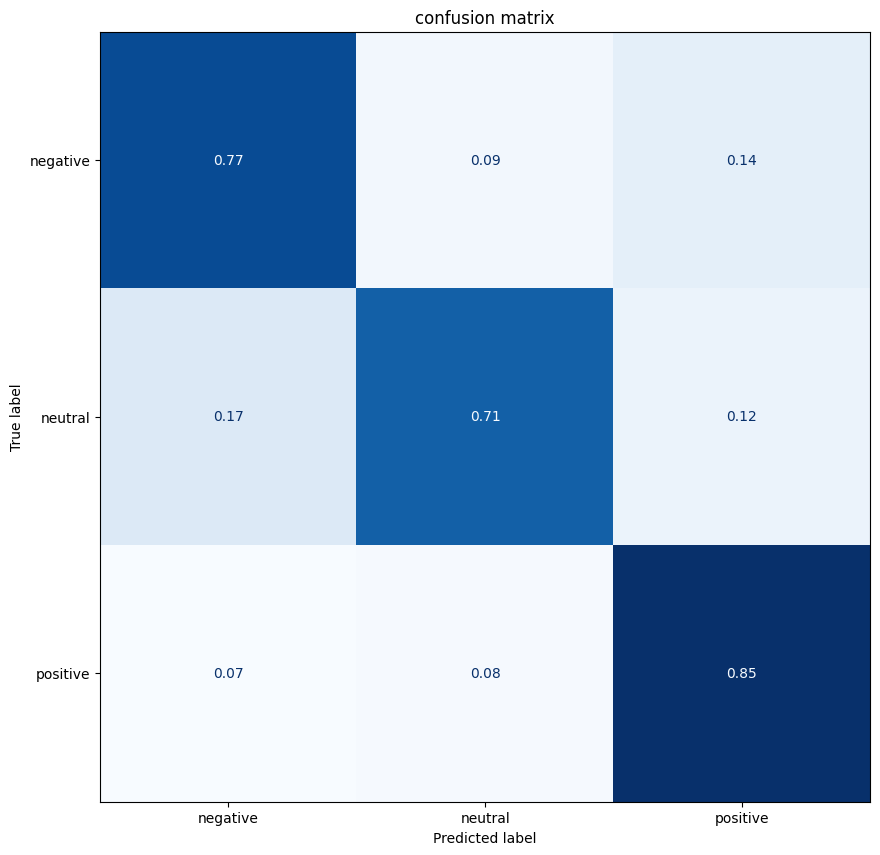

In [62]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## validation_dataset

In [63]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 209
  Batch size = 32


In [64]:
preds_output.metrics

{'test_loss': 0.6917774081230164,
 'test_accuracy': 0.8277511961722488,
 'test_f1': 0.8214169519728683,
 'test_precision': 0.8279074592800083,
 'test_recall': 0.8220129375951294,
 'test_runtime': 32.083,
 'test_samples_per_second': 6.514,
 'test_steps_per_second': 0.218}

In [65]:
y_preds = np.argmax(preds_output.predictions, axis=1)

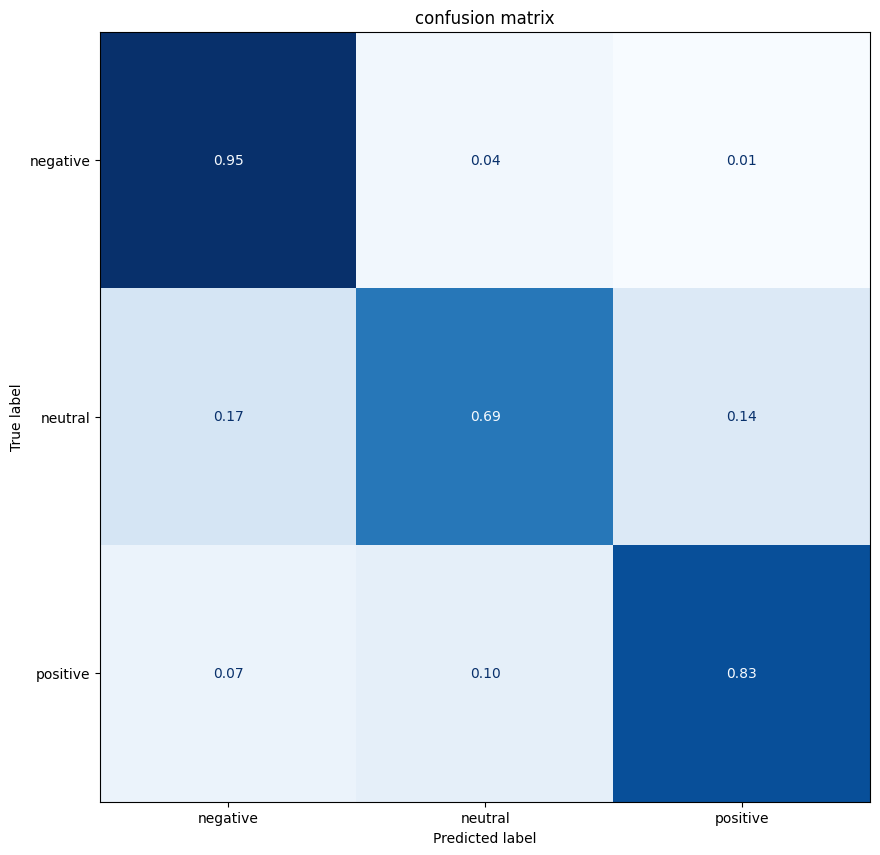

In [66]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

# Non-normalize

In [67]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
#     cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

## test

In [68]:
y_valid = np.array(test_dataset["label"])
preds_output = trainer.predict(test_dataset)
preds_output.metrics

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 674
  Batch size = 32


{'test_loss': 0.8892951607704163,
 'test_accuracy': 0.7804154302670623,
 'test_f1': 0.7779997363383577,
 'test_precision': 0.7810871249620747,
 'test_recall': 0.777556496003098,
 'test_runtime': 105.9882,
 'test_samples_per_second': 6.359,
 'test_steps_per_second': 0.208}

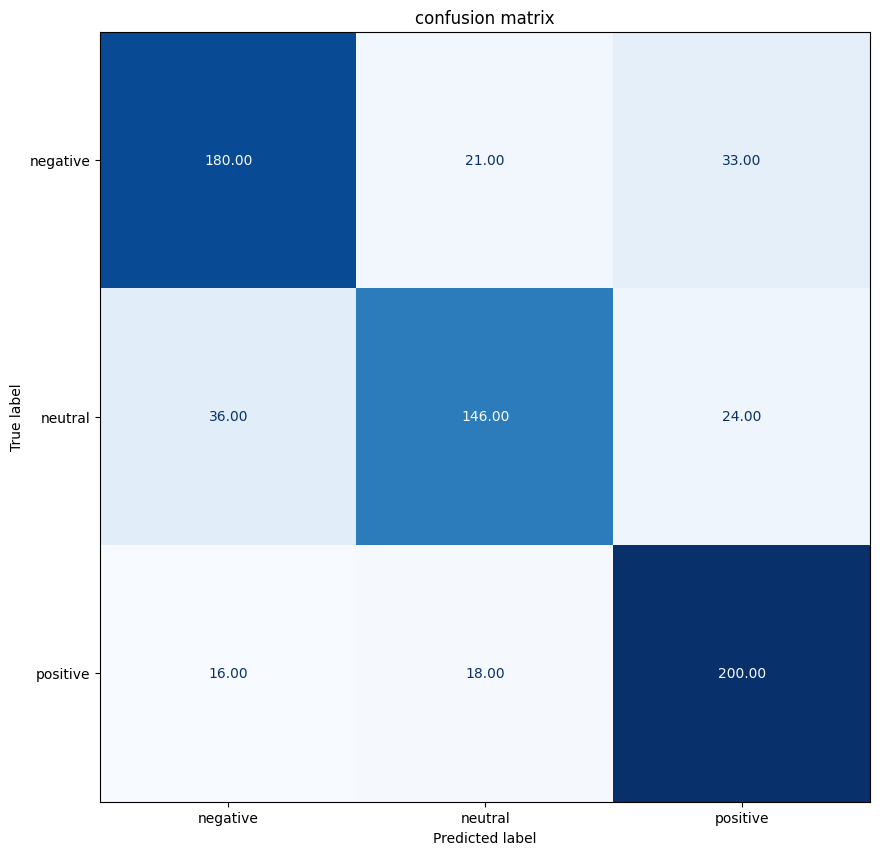

In [69]:
y_preds = np.argmax(preds_output.predictions, axis=1)
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## validation

In [70]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)
preds_output.metrics

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 209
  Batch size = 32


{'test_loss': 0.6917774081230164,
 'test_accuracy': 0.8277511961722488,
 'test_f1': 0.8214169519728683,
 'test_precision': 0.8279074592800083,
 'test_recall': 0.8220129375951294,
 'test_runtime': 32.1495,
 'test_samples_per_second': 6.501,
 'test_steps_per_second': 0.218}

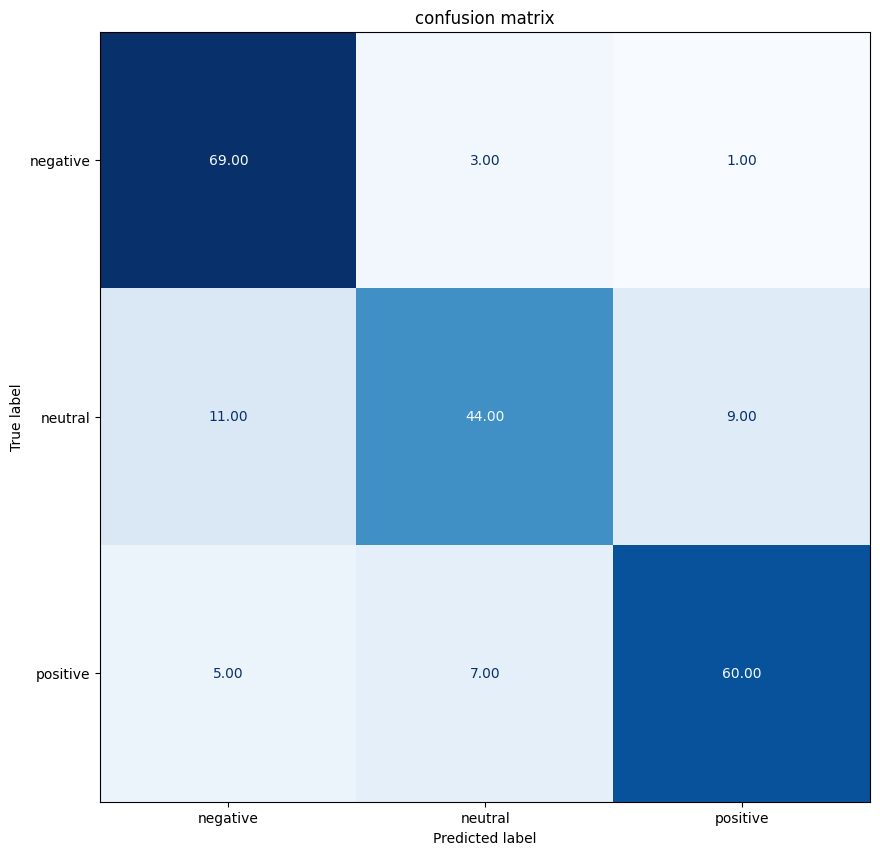

In [71]:
y_preds = np.argmax(preds_output.predictions, axis=1)
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

# Save

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "./SA_results/my_model"
    ,num_labels=train_dataset.features["label"].num_classes,
    ignore_mismatched_sizes=True
)

model.config

In [75]:
model.push_to_hub("my_model_ExperimentSA_0.8")
tokenizer.push_to_hub("my_model_ExperimentSA_0.8")

Configuration saved in C:\Users\RESEAR~1\AppData\Local\Temp\tmp5tzuzfmf\config.json
Model weights saved in C:\Users\RESEAR~1\AppData\Local\Temp\tmp5tzuzfmf\pytorch_model.bin
Uploading the following files to HFFErica/my_model_ExperimentSA_0.8: config.json,pytorch_model.bin
tokenizer config file saved in C:\Users\RESEAR~1\AppData\Local\Temp\tmp8xobo4o0\tokenizer_config.json
Special tokens file saved in C:\Users\RESEAR~1\AppData\Local\Temp\tmp8xobo4o0\special_tokens_map.json
Uploading the following files to HFFErica/my_model_ExperimentSA_0.8: merges.txt,special_tokens_map.json,tokenizer.json,tokenizer_config.json,vocab.json


CommitInfo(commit_url='https://huggingface.co/HFFErica/my_model_ExperimentSA_0.8/commit/a1c1a0e8e415dcc48b9bd0c5ee9ffe8c51e9517e', commit_message='Upload tokenizer', commit_description='', oid='a1c1a0e8e415dcc48b9bd0c5ee9ffe8c51e9517e', pr_url=None, pr_revision=None, pr_num=None)

# Prediction

In [37]:
model = AutoModelForSequenceClassification.from_pretrained("./SA_results/my_model_nms")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [43]:
df_ron = pd.read_csv('./datasets/NMS-BERTopic.csv', encoding='utf-8')

In [44]:
df_ron

In [41]:
# df_ron_selec=df_ron.sample(frac=0.05,random_state=2000)
# df_ron_selec

In [45]:
%time
ron_results = classifier(df_ron['Document'].to_list())

In [46]:
name=['label','score']
label_results=pd.DataFrame(columns=name,data=ron_results)
print(label_results)
label_results.to_csv('./datasets/nmsSA_labels.csv',encoding='utf-8', index=False)

In [47]:
df_ron['sentiment'] = label_results['label']

In [48]:
df_ron['sentiment'] = label_results['label']

In [49]:
df_ron.to_csv('./datasets/nms_all_labels.csv',index=False)

In [50]:
df_ron

In [51]:
df_ron.sentiment.value_counts().plot(kind = 'pie', autopct="%.2f")